## Prepare segpc dataset
Here, we want to use the SegPC2021 database to create an independent image centered on the nucleus for each desired cell in this dataset, with the ultimate goal of obtaining the cytoplasm of that cell. Also, the nucleus mask will be used as an auxiliary channel in the input images. You can refer to [this article](https://arxiv.org/abs/2105.06238) for more information.

In [1]:
from configparser import ConfigParser
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import cv2, sys, os, glob
from PIL import Image
import pickle
from pathlib import Path
import json
import gc

import imageio.v2 as imageio
import random

from scipy.ndimage.morphology import binary_erosion, binary_dilation, binary_fill_holes
from scipy import ndimage

/tmp/ipykernel_2411000/479811753.py:15: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_erosion, binary_dilation, binary_fill_holes
/tmp/ipykernel_2411000/479811753.py:15: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_erosion, binary_dilation, binary_fill_holes
/tmp/ipykernel_2411000/479811753.py:15: DeprecationWarning: Please use `binary_fill_holes` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_erosion, binary_dilation, binary_fill_holes


In [6]:
# Parameters
HEIGHT = 1080
WIDTH = 1440
CHANNELS = 3

INPUT_SIZE = (224, 224)
GENERATE_NEW_DATA = True
SCALES = [2.5]

###################################################
DATASET_DIR   = '/raid/home/labusermodaresi/datasets/TCIA_SegPC_dataset/'
TRAIN_DIR     = DATASET_DIR + 'train/'
VAL_DIR       = DATASET_DIR + 'validation/'
SAVE_DATA_IN  = '/raid/home/labusermodaresi/datasets/TCIA_SegPC_dataset/np'

TRAIN_X_DIR   = TRAIN_DIR   + 'x/'
TRAIN_Y_DIR   = TRAIN_DIR   + 'y/'
VAL_X_DIR     = VAL_DIR     + 'x/'
VAL_Y_DIR     = VAL_DIR     + 'y/'

FILE_TYPE_EXTENSION = '.bmp'
VISUALIZE_DIR = '../visualize/'


from pathlib import Path
# Path(VISUALIZE_DIR).mkdir(parents=True, exist_ok=True)
Path(TRAIN_X_DIR).mkdir(parents=True, exist_ok=True)
Path(TRAIN_Y_DIR).mkdir(parents=True, exist_ok=True)

Path(SAVE_DATA_IN+"/x").mkdir(parents=True, exist_ok=True)
Path(SAVE_DATA_IN+"/y").mkdir(parents=True, exist_ok=True)

In [3]:
import cv2
import numpy as np
import cv2
import numpy as np

def resize_pad(image, size):
    # Resizes the image while maintaining aspect ratio and pads it to the specified size

    # Get the original image dimensions
    resized_img=sim_resize(image,size)
    target_height,target_width=resized_img.shape[0:2]
    # Calculate the aspect ratio of the original image
    
    # Create a new blank canvas with the target size and same number of channels as the original image
    canvas = np.zeros((size[0], size[1], resized_img.shape[-1]), dtype=image.dtype)

    # Calculate the starting position to paste the resized image onto the canvas
    start_x = (size[0] - target_width) // 2
    start_y = (size[1] - target_height) // 2

    # Paste the resized image onto the canvas
    canvas[start_y:start_y + target_height, start_x:start_x + target_width] = resized_img

    return canvas

def sim_resize(image, size):
    # Resizes the image to the specified size while preserving aspect ratio

    # Get the original image dimensions
    original_height, original_width = image.shape[:2]

    # Calculate the aspect ratio of the original image
    aspect_ratio = original_width / original_height

    # Determine the target width and height while maintaining the aspect ratio
    target_width, target_height = size
    if target_width / target_height > aspect_ratio:
        target_width = int(target_height * aspect_ratio)
    else:
        target_height = int(target_width / aspect_ratio)

    # Resize the image using OpenCV
    resized_image = cv2.resize(image, (target_width, target_height))

    
    # print(resized_image.reshape(target_width, target_height,-1).shape)
    return resized_image.reshape(target_height,target_width,-1)
# img = imageio.imread(yp)
# plt.imshow(img)
# img   = resize_pad(ins_scale['snmsk' ], INPUT_SIZE)
#                 snmsk = resize_pad(ins_scale['snmsk'], INPUT_SIZE)
#                 scmsk = resize_pad(ins_scale['scmsk'], INPUT_SIZE)
# plt.imshow(img)

loading data

In [7]:
def split_c_n(img, nv=40, cv=20):
    nim = np.where(img>=nv, 1, 0)
    cim = np.where(img>=cv, 1, 0) - nim
    return cim, nim

def get_ins_list(image_path, desire_margin_list=[0], is_train=True):
    xp = image_path
    fn = xp.split('/')[-1].split(FILE_TYPE_EXTENSION)[0]
    img = imageio.imread(xp)
    img = cv2.resize(img, (HEIGHT, WIDTH))
    
    if is_train:
        yp_list = glob.glob(f'{TRAIN_Y_DIR}{fn}_*{FILE_TYPE_EXTENSION}')
    else:
        yp_list = glob.glob(f'{VAL_Y_DIR  }{fn}_*{FILE_TYPE_EXTENSION}')
        
    all_inst_data_list = []
    for yp in yp_list:
        msk = imageio.imread(yp)
        msk = cv2.resize(msk, (HEIGHT, WIDTH))

        if len(msk.shape)==3: msk = msk[:,:,0]
        cim, nim = split_c_n(msk)
        cim = np.where(cim>0, 255, 0)    
        nim = np.where(nim>0, 255, 0)
        

        ## crop nucleus
        idxs, idys = np.nonzero(nim)
        n_bbox = [min(idxs), min(idys), max(idxs)+1, max(idys)+1]
        idxs, idys = np.nonzero(cim)
        c_bbox = [min(idxs), min(idys), max(idxs)+1, max(idys)+1]
        bbox = [
            max(0           ,n_bbox[0]), max(0           ,n_bbox[1]),
            min(img.shape[0],n_bbox[2]), min(img.shape[1],n_bbox[3]),
        ]
        n_img = img[bbox[0]:bbox[2],bbox[1]:bbox[3]]
        n_msk = nim[bbox[0]:bbox[2],bbox[1]:bbox[3]]
        
        all_scales_data_list = []
        for scale in desire_margin_list:
            dx = round(scale*n_msk.shape[0]/2)
            dy = round(scale*n_msk.shape[1]/2)
            
            dx, dy = int(dx), int(dy)
            
            snmsk = np.zeros((n_msk.shape[0]+2*dx, n_msk.shape[1]+2*dy), dtype=np.uint8)
            scmsk = np.zeros((n_msk.shape[0]+2*dx, n_msk.shape[1]+2*dy), dtype=np.uint8)
            simg  = np.zeros((n_msk.shape[0]+2*dx, n_msk.shape[1]+2*dy, 3), dtype=np.uint8)
            
            bbox = [
                max(0           ,n_bbox[0]-dx),max(0           ,n_bbox[1]-dy),
                min(img.shape[0],n_bbox[2]+dx),min(img.shape[1],n_bbox[3]+dy),
            ]       
            
            timg  = img[bbox[0]:bbox[2],bbox[1]:bbox[3]]
            tnmsk = nim[bbox[0]:bbox[2],bbox[1]:bbox[3]]
            tcmsk = cim[bbox[0]:bbox[2],bbox[1]:bbox[3]]
            
            shift_x = round((simg.shape[0]-timg.shape[0])/2)
            shift_y = round((simg.shape[1]-timg.shape[1])/2)
            simg [shift_x:timg.shape[0] +shift_x, shift_y:timg.shape[1] +shift_y, :] = timg
            snmsk[shift_x:tnmsk.shape[0]+shift_x, shift_y:tnmsk.shape[1]+shift_y] = tnmsk
            scmsk[shift_x:tcmsk.shape[0]+shift_x, shift_y:tcmsk.shape[1]+shift_y] = tcmsk
                    
            is_cyto_fully_cov = (
                (bbox[0]<=c_bbox[0])and(bbox[1]<=c_bbox[1])
            ) and (
                (bbox[2]>=c_bbox[2])and(bbox[3]>=c_bbox[3])
            )
            tdata = {
                'scale': scale,
                'bbox': bbox,
                'bbox_hint': "[x_min, y_min, x_max, y_max]",
                'shift': [shift_x, shift_y],
                'simg_size': snmsk.shape,
                'simg': simg,
                'snmsk': snmsk,
                'scmsk': scmsk,
                'is_cyto_fully_cov': is_cyto_fully_cov
            }            
            all_scales_data_list.append(tdata)

        all_inst_data_list.append(all_scales_data_list)
    
    data = {
        'meta': {
            'image_name' : fn,
            'image_path' : xp,
            'image_size' : img.shape,
            'total_insts': len(all_inst_data_list)
        },
        'data': all_inst_data_list
    }

    return data


def split_segpc_train_test(X, Y, tr_p=0.5, vl_p=0.2):
    total = len(X)

    tr_vl_idx = int(total*tr_p)
    vl_te_idx = int(total*(tr_p+vl_p))

    X_tr = X[         :tr_vl_idx]
    X_vl = X[tr_vl_idx:vl_te_idx]
    X_te = X[vl_te_idx:         ]

    Y_tr = Y[         :tr_vl_idx]
    Y_vl = Y[tr_vl_idx:vl_te_idx]
    Y_te = Y[vl_te_idx:         ]
    
    return X_tr, X_vl, X_te, Y_tr, Y_vl, Y_te


if GENERATE_NEW_DATA:
    
    # for train folder
    tr_X_path_list = glob.glob(TRAIN_X_DIR+'*'+FILE_TYPE_EXTENSION)
    tr_X, tr_Y = [], []
    for xp in tqdm(tr_X_path_list, desc="Train"): 
        for ins in get_ins_list(xp, SCALES)['data']:
            for ins_scale in ins:
                img   = resize_pad(ins_scale['simg' ], INPUT_SIZE)
                snmsk = resize_pad(ins_scale['snmsk'], INPUT_SIZE).reshape(INPUT_SIZE)
                scmsk = resize_pad(ins_scale['scmsk'], INPUT_SIZE).reshape(INPUT_SIZE)
#                 for i in range(3):
#                     img[:,:,i] = cv2.equalizeHist(np.uint8(img[:,:,i]))
                x = np.concatenate([img, np.expand_dims(snmsk, -1)], -1)
                tr_X.append(np.uint8(x))
                tr_Y.append(np.uint8(scmsk+snmsk))   

    print(len(tr_X))
    # for test folder
    val_X_path_list = glob.glob(VAL_X_DIR+'*'+FILE_TYPE_EXTENSION)
    val_X, val_Y = [], []
    for xp in tqdm(val_X_path_list, desc="Validation"):   
        for ins in get_ins_list(xp, SCALES, False)['data']:
            for ins_scale in ins:
                img   = resize_pad(ins_scale['simg' ], INPUT_SIZE)
                snmsk = resize_pad(ins_scale['snmsk'], INPUT_SIZE).reshape(INPUT_SIZE)
                scmsk = resize_pad(ins_scale['scmsk'], INPUT_SIZE).reshape(INPUT_SIZE)
#                 for i in range(3):
#                     img[:,:,i] = cv2.equalizeHist(np.uint8(img[:,:,i]))
                x = np.concatenate([img, np.expand_dims(snmsk, -1)], -1)
                val_X.append(np.uint8(x))
                val_Y.append(np.uint8(scmsk+snmsk))   

    # split to train and validation
    print('converting list of images to numpy array...')
    X = np.array(tr_X + val_X)
    Y = np.array(tr_Y + val_Y)
    print(f"total-X: {X.shape}, total-Y: {Y.shape}")
    
    X_tr, X_vl, X_te, Y_tr, Y_vl, Y_te = split_segpc_train_test(X, Y, tr_p=0.5, vl_p=0.2)
    print(f"tr:{X_tr.shape}, vl:{X_vl.shape}, te:{X_te.shape}")
    
    numpy_X = X_tr.copy()
    numpy_Y = Y_tr.copy()
    # ===================== finished data augmentation ====================

    
    # ------------------------- start storing -----------------------
    ADD = SAVE_DATA_IN
    
    # total
    print('saving X...')
    np.save(f'{ADD}/cyts_{INPUT_SIZE[0]}x{INPUT_SIZE[1]}_s{SCALES[0]}_X', X)
    print('saving Y...')
    np.save(f'{ADD}/cyts_{INPUT_SIZE[0]}x{INPUT_SIZE[1]}_s{SCALES[0]}_Y', Y)
    print('finished.')
    
    # train
    print('saving X_tr...')
    np.save(f'{ADD}/cyts_tr_{INPUT_SIZE[0]}x{INPUT_SIZE[1]}_s{SCALES[0]}_X', X_tr)
    print('saving Y_tr...')
    np.save(f'{ADD}/cyts_tr_{INPUT_SIZE[0]}x{INPUT_SIZE[1]}_s{SCALES[0]}_Y', Y_tr)
    print('finished.')
    
    # validation 
    print('saving X_vl...')
    np.save(f'{ADD}/cyts_vl_{INPUT_SIZE[0]}x{INPUT_SIZE[1]}_s{SCALES[0]}_X', X_vl)
    print('saving Y_vl...')
    np.save(f'{ADD}/cyts_vl_{INPUT_SIZE[0]}x{INPUT_SIZE[1]}_s{SCALES[0]}_Y', Y_vl)
    print('finished.')
    
    # test
    print('saving X_te...')
    np.save(f'{ADD}/cyts_te_{INPUT_SIZE[0]}x{INPUT_SIZE[1]}_s{SCALES[0]}_X', X_te)
    print('saving Y_te...')
    np.save(f'{ADD}/cyts_te_{INPUT_SIZE[0]}x{INPUT_SIZE[1]}_s{SCALES[0]}_Y', Y_te)
    print('finished.')
    # ===============================================================


else:
    # ------------------------- start loading -----------------------
    ADD = SAVE_DATA_IN
    
    # total
    print('saving X...')
    X = np.load(f'{ADD}/cyts_{INPUT_SIZE[0]}x{INPUT_SIZE[1]}_s{SCALES[0]}_X')
    print('saving Y...')
    Y = np.load(f'{ADD}/cyts_{INPUT_SIZE[0]}x{INPUT_SIZE[1]}_s{SCALES[0]}_Y')
    print('finished.')
    
    # train
    print('saving X_tr...')
    X_tr = np.load(f'{ADD}/cyts_tr_{INPUT_SIZE[0]}x{INPUT_SIZE[1]}_s{SCALES[0]}_X')
    print('saving Y_tr...')
    Y_tr = np.load(f'{ADD}/cyts_tr_{INPUT_SIZE[0]}x{INPUT_SIZE[1]}_s{SCALES[0]}_Y')
    print('finished.')
    
    # validation 
    print('saving X_vl...')
    X_vl = np.load(f'{ADD}/cyts_vl_{INPUT_SIZE[0]}x{INPUT_SIZE[1]}_s{SCALES[0]}_X')
    print('saving Y_vl...')
    Y_vl = np.load(f'{ADD}/cyts_vl_{INPUT_SIZE[0]}x{INPUT_SIZE[1]}_s{SCALES[0]}_Y')
    print('finished.')
    
    # test
    print('saving X_te...')
    X_te = np.load(f'{ADD}/cyts_te_{INPUT_SIZE[0]}x{INPUT_SIZE[1]}_s{SCALES[0]}_X')
    print('saving Y_te...')
    Y_te = np.load(f'{ADD}/cyts_te_{INPUT_SIZE[0]}x{INPUT_SIZE[1]}_s{SCALES[0]}_Y')
    print('finished.')
    
    numpy_X = X_tr.copy()
    numpy_Y = Y_tr.copy()
    # ===============================================================

Train: 100%|██████████| 298/298 [01:11<00:00,  4.19it/s]


1643


Validation: 100%|██████████| 200/200 [00:45<00:00,  4.37it/s]


converting list of images to numpy array...
total-X: (2633, 224, 224, 4), total-Y: (2633, 224, 224)
tr:(1316, 224, 224, 4), vl:(527, 224, 224, 4), te:(790, 224, 224, 4)
saving X...
saving Y...
finished.
saving X_tr...
saving Y_tr...
finished.
saving X_vl...
saving Y_vl...
finished.
saving X_te...
saving Y_te...
finished.


In [9]:
numpy_X.shape

(1316, 224, 224, 4)

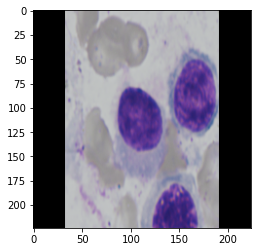

In [8]:
plt.imshow(numpy_X[100,:,:,:-1])
plt.show()